<a href="https://colab.research.google.com/github/ayushmangupta/TF2/blob/master/VAE_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
#!pip3 install tensorflow-gpu==2.0.0-beta1
#!pip install MulticoreTSNE
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE
print(tf.__version__)

%matplotlib inline 

  Stored in directory: /root/.cache/pip/wheels/27/59/53/3b52ee63add3692254c30d687fa4dff4d128d0557861fb028e
Successfully built MulticoreTSNE
2.0.0-beta1


In [6]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = tf.cast(x_train,tf.float32)
x_test = tf.cast(x_test,tf.float32)

x_train = tf.reshape(x_train,shape=[60000,784])
x_test = tf.reshape(x_test,shape=[10000,784])
# Add a channels dimension
#x_train = x_train[..., tf.newaxis]
#x_test = x_test[..., tf.newaxis]
#print(x_train.shape)
#Use tf.data to batch and shuffle the dataset:



11493376/11490434 [==============================] - 0s 0us/step


In [0]:
class Sampling(tfk.Model):
  def call(self,args):
    z_mean, z_log_var =  args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch,dim),mean=0.0,stddev=1.0)
    return z_mean + epsilon * tf.exp(0.5*z_log_var) 
    
    
    
    

In [0]:
class Encoder(tfk.Model):
  def __init__(self,hidden_dim,orignal_dim,latent_dim):
    super(Encoder,self).__init__()
    self.common_layer = []
    self.common_layer.append(tfkl.InputLayer(input_shape=orignal_dim))
    self.common_layer.append(tfkl.Dense(units=hidden_dim,activation='relu'))
    self.sampling = Sampling()
    self.z_mean_layer = tfkl.Dense(units=latent_dim)
    self.z_log_var_layer = tfkl.Dense(units=latent_dim)
  
  def call(self,x):
    x = tf.reshape(x,[-1,orignal_dim])
    for layer in self.common_layer:
      x = layer(x)
    z_mean =  self.z_mean_layer(x)
    z_log_var = self.z_log_var_layer(x)
    z = self.sampling((z_mean,z_log_var))
    print("z shape ",z.shape)
    return z_mean, z_log_var, z
      

In [0]:
class Decoder(tfk.Model):
  def __init__(self,hidden_dim,latent_dim,orignal_dim):
    
    super(Decoder,self).__init__()
    self.common_layer = []
    self.common_layer.append(tfkl.Dense(units=hidden_dim, activation='relu'))
    self.common_layer.append(tfkl.Dense(units=orignal_dim,activation='sigmoid'))
 

  def call(self,x):
    x = tf.reshape(x,[-1,latent_dim])
    for layer in self.common_layer:
      x = layer(x)
      
    return x    

In [0]:
class VAE(tfk.Model):
  def __init__(self,hidden_dim,latent_dim,orignal_dim):
    super(VAE,self).__init__()
    
    self.encoder = Encoder(hidden_dim = hidden_dim,latent_dim=latent_dim,orignal_dim=orignal_dim)
    self.decoder = Decoder(hidden_dim,latent_dim,orignal_dim)
    
    
  def call(self,x):
    z_mean, z_log_var, latent_code = self.encoder(x)
    reconstructed = self.decoder(latent_code)
    kl_divergence = -5e-2 * tf.reduce_sum(tf.exp(z_log_var) + tf.square(z_mean) - 1 - z_log_var)   
    self.add_loss(kl_divergence)
    return reconstructed

In [0]:
latent_dim = 10
orignal_dim = 784
hidden_dim=128
vae = VAE(hidden_dim,latent_dim, orignal_dim)

In [0]:
# def loss_function(x,x_hat):
#   #print(x.dtype,x_hat.dtype)
#   reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(x,x_hat)))
#   return reconstruction_error

loss_function =mse_loss_fn = tf.keras.losses.BinaryCrossentropy()

optimizer = tf.keras.optimizers.Adam(0.0003)

train_loss = tf.keras.metrics.Mean(name='train_loss')

test_loss = tf.keras.metrics.Mean(name='test_loss')


In [0]:
@tf.function
def train_step(x):
  with tf.GradientTape() as tape:
    z_mean,z_log_var,z = vae.encoder(x)
    reconstructed = vae.decoder(z)
    
    print("model_out")
    loss = loss_function(x,reconstructed)
    loss += sum(vae.losses)
    print("loss out",loss)
  gradients = tape.gradient(loss, vae.trainable_variables)
  optimizer.apply_gradients(zip(gradients, vae.trainable_variables))

  train_loss(loss)


@tf.function
def test_step(images):
  predictions = model(images)
  t_loss = loss_function(images,predictions)

  test_loss(t_loss)
  #test_accuracy(labels, predictions)

In [14]:
EPOCHS = 200

for epoch in range(EPOCHS):
  for images in train_ds:
    train_step(images)

#   for test_images in test_ds:
#     test_step(test_images)

  template = 'Epoch {},Train Loss: {}'#,Test Loss: {}'
  #template = "EPOCH {} Loss {} "
  if epoch%10==0:
    print (template.format(epoch+1,
                         train_loss.result(),test_loss.result()))  

Epoch 141,Train Loss: 0.11005304753780365
Epoch 151,Train Loss: 0.10975069552659988
Epoch 161,Train Loss: 0.10947629064321518
Epoch 171,Train Loss: 0.1092282384634018
Epoch 181,Train Loss: 0.1090012788772583
Epoch 191,Train Loss: 0.10879231244325638


In [52]:

test_ds = tf.data.Dataset.from_tensor_slices(
     (x_test)).shuffle(10000).batch(10)

for images in test_ds:
  imgs = images
  break

noisy_images = imgs + tf.random.normal(shape=imgs.shape,stddev= 8e-2)

_,_,l_Z=vae.encoder(noisy_images)
recon = vae.decoder(l_Z)

z shape  (10, 10)


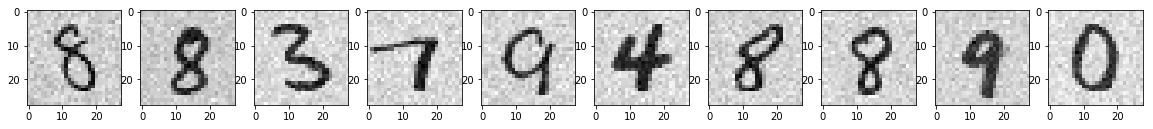

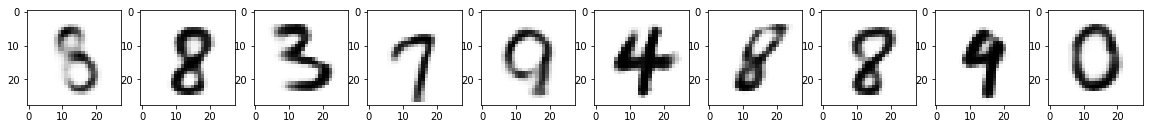

In [53]:
plt.figure(figsize=(20,12))


for i in range(10):
  plt.subplot(1,10,i+1)
  plt.imshow(tf.reshape(noisy_images[i],[28,28]),cmap="binary")
  

  
  
plt.show()
plt.figure(figsize=(20,12))

for i in range(10):
  plt.subplot(1,10,i+1)
  #plt.imshow(tf.reshape(noisy_images[i],[28,28]),cmap="binary")
  
  
  plt.imshow(tf.reshape(recon[i],[28,28]),cmap="binary")
  
  
plt.show()

z shape  (10, 10)


In [0]:
from google.colab import files
vae.save_weights("vae.h5")

In [0]:
pca = PCA(n_components=10)
reduce_training_feature = pca.fit_transform(x_train)
reduce_testing_feature = pca.transform(x_test)

In [0]:
noisy_images = x_test + tf.random.normal(shape=x_test.shape,stddev= 8e-2)
tsne = TSNE(n_components=2, n_jobs=8, perplexity=150)
x_test_tsne = tsne.fit_transform(noisy_images)


_,_,l_Z=vae.encoder(noisy_images)
recon = vae.decoder(l_Z)
x_test_tsne_recon = tsne.fit_transform(recon)

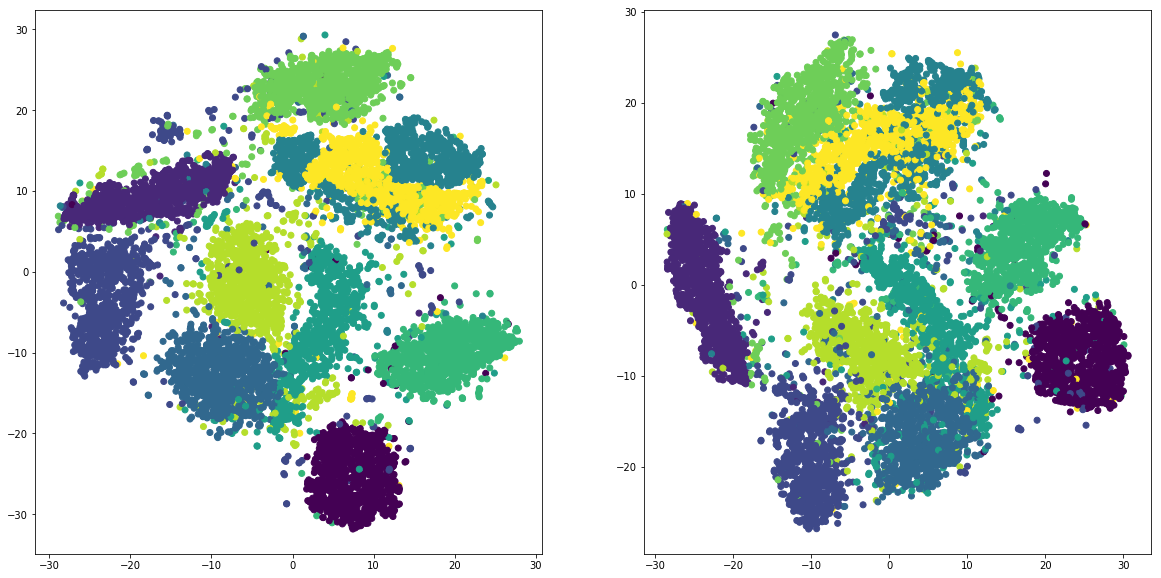

In [76]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(x_test_tsne[:,0],x_test_tsne[:,1],c=y_test)

plt.subplot(1,2,2)
plt.scatter(x_test_tsne_recon[:,0],x_test_tsne_recon[:,1],c=y_test)

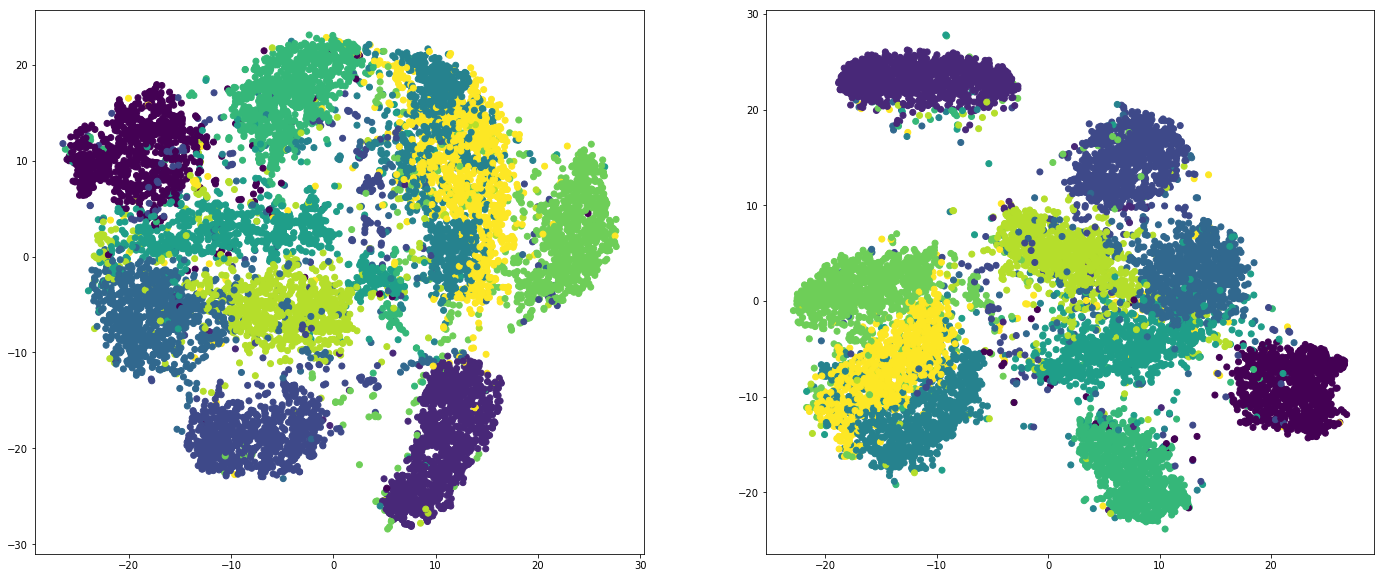

In [80]:
plt.figure(figsize=(24,10))
plt.subplot(1,2,1)
tsne = TSNE(n_components=2, n_jobs=8, perplexity=150)
pc_tsne = tsne.fit_transform(reduce_testing_feature)
plt.scatter(pc_tsne[:,0],pc_tsne[:,1],c=y_test)


plt.subplot(1,2,2)
tsne = TSNE(n_components=2, n_jobs=8, perplexity=150)
z_tsne = tsne.fit_transform(l_Z)
plt.scatter(z_tsne[:,0],z_tsne[:,1],c=y_test) 